# Import Library & Dataset

In [1]:
import pandas as pd
import numpy as np

DATA_PATH = '../data/cleaned_outliers_data_saudi_used_cars.csv'
OUTPUT_PATH = '../data/feature_engineered_saudi_used_cars.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(3801, 11)


,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000


# Feature Engineering

## Feature Creation

### Car Age

In [2]:
# -- Car Age: More predictive than raw Year --
CURRENT_YEAR = 2022
df['Car_Age'] = CURRENT_YEAR - df['Year']
# Business logic: car age is a more monotonic predictor of price drop
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,8
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,7
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,7
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,3
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,10


### Vintage Cars (IsVintage)

In [3]:
# -- Vintage Flag: Flag cars that are "classic" or "vintage", which is indicated by a Car Age of 30 years or older --
df['IsVintage'] = (df['Car_Age'] >= 30)
df[df['IsVintage']].head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age,IsVintage
42,SEL,Tabouk,Mercedes,Automatic,Saudi,Full,1986,3.0,500000,False,5500,36,True
204,Land Cruiser Pickup,Aseer,Toyota,Manual,Saudi,Standard,1983,1.5,2580,False,15000,39,True
285,SEL,Dammam,Mercedes,Automatic,Other,Full,1990,4.0,89000,False,75000,32,True
441,Other,Qassim,Other,Manual,Other,Standard,1980,2.4,2500,False,220000,42,True
953,Land Cruiser,Najran,Toyota,Manual,Saudi,Semi Full,1988,4.0,195000,False,30000,34,True


### Big Engine Cars (IsBigEngine)

In [4]:
# -- Big Engine Flag: Flag abnormally high-performance vehicles
df['IsBigEngine'] = (df['Engine_Size'] > 7.0)
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Car_Age,IsVintage,IsBigEngine
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000,8,False,True
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000,7,False,False
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000,7,False,False
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000,3,False,False
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000,10,False,False


## Feature Transformation

Log-transform skewed numerical columns

In [5]:
def analyze_features(df, target_var='Price', low_card_thresh=10):
  """
  Analyze dataframe features for modeling:
  - Identifies categorical and numerical columns (excluding target)
  - Detects highly skewed numeric columns
  - Splits categoricals into low/high cardinality
  - Prints summary

  Returns:
    cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat
  """
  # Categorical columns for future pipeline/modeling
  cat_cols = (
    df
      .select_dtypes(include=['object','bool','category'])
      .drop(columns=[target_var], errors='ignore')
      .columns
      .tolist()
  )

  # Numerical columns (excluding target)
  num_cols = (
    df
      .select_dtypes(include=['int64','float64'])
      .drop(columns=[target_var])
      .columns
      .tolist()
  )

  print("Categorical variables:", cat_cols)
  print("Numerical variables:", num_cols)
  print("Target variable:", target_var)

  # detect highly-skewed numerics for log1p transform
  skewed_cols = [c for c in num_cols if abs(df[c].skew()) > 1.0]
  print("Highly skewed numeric columns:", skewed_cols)

  print("\n>> category cardinalities:")
  for c in cat_cols:
    print(f"   {c:12s}: {df[c].nunique()} categories")

  # split them into "low-cardinality" vs "high-cardinality"
  low_card_cat  = [c for c in cat_cols if df[c].nunique() <= low_card_thresh]
  high_card_cat = [c for c in cat_cols if df[c].nunique() >  low_card_thresh]

  # a quick sanity check
  print("\n>> low-cardinal cats:",  low_card_cat)
  print(">> high-cardinal cats:", high_card_cat)
  print(">> numeric cols:     ",  num_cols)
  print(">> skewed cols:     ",  skewed_cols)

  return cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat

In [6]:
cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat = analyze_features(df)

Categorical variables: ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'Negotiable', 'IsVintage', 'IsBigEngine']
Numerical variables: ['Year', 'Engine_Size', 'Mileage', 'Car_Age']
Target variable: Price
Highly skewed numeric columns: ['Year', 'Mileage', 'Car_Age']

>> category cardinalities:
   Type        : 319 categories
   Region      : 27 categories
   Make        : 56 categories
   Gear_Type   : 2 categories
   Origin      : 4 categories
   Options     : 3 categories
   Negotiable  : 1 categories
   IsVintage   : 2 categories
   IsBigEngine : 2 categories

>> low-cardinal cats: ['Gear_Type', 'Origin', 'Options', 'Negotiable', 'IsVintage', 'IsBigEngine']
>> high-cardinal cats: ['Type', 'Region', 'Make']
>> numeric cols:      ['Year', 'Engine_Size', 'Mileage', 'Car_Age']
>> skewed cols:      ['Year', 'Mileage', 'Car_Age']


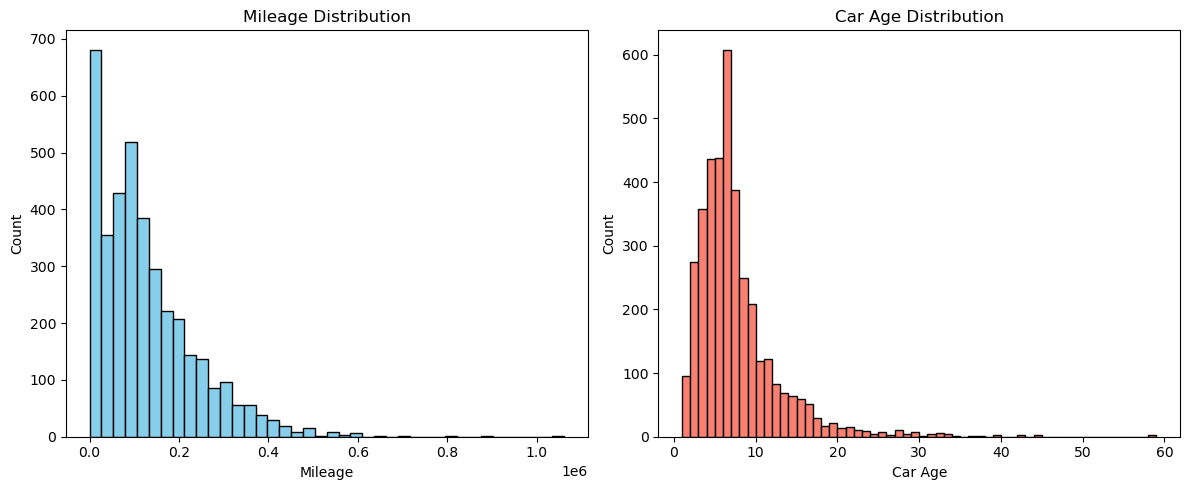

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mileage distribution
axes[0].hist(df['Mileage'], bins=40, color='skyblue', edgecolor='black')
axes[0].set_title('Mileage Distribution')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Count')

# Car_Age distribution
axes[1].hist(df['Car_Age'], bins=range(df['Car_Age'].min(), df['Car_Age'].max() + 1), color='salmon', edgecolor='black')
axes[1].set_title('Car Age Distribution')
axes[1].set_xlabel('Car Age')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
# -- Log Transform for Skewed Numeric Features (Optional, for linear models) --
df['log_Mileage'] = np.log1p(df['Mileage'])
# Tree-based models (CatBoost, LightGBM) don't require this, but keep for benchmarking
display(df[['log_Mileage', 'Mileage']].sort_values(by='log_Mileage').head())
display(df[['log_Mileage', 'Mileage']].sort_values(by='log_Mileage').tail())

,log_Mileage,Mileage
3383,4.615121,100
2083,4.615121,100
857,4.615121,100
3540,4.615121,100
2628,4.615121,100


,log_Mileage,Mileage
3116,13.470201,708000
1648,13.594241,801500
1311,13.710151,900000
383,13.710151,900000
2794,13.873973,1060204


## Feature Selection

In [9]:
# -- Drop Columns Not Needed for Modeling --
drop_cols = ['Negotiable', 'Mileage_per_Year', 'Unnatural_High_Mileage_Flag', 'Year']
for col in drop_cols:
    if col in df.columns:
        df = df.drop(columns=col)
# Negotiable: already removed from pipeline.
# Mileage_per_Year, Unnatural_High_Mileage_Flag: only for outlier detection, not features.
# Year: we already created 'Car_Age' from it, so it's redundant.

df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,Car_Age,IsVintage,IsBigEngine,log_Mileage
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,8.0,80000,120000,8,False,True,11.289794
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,5.0,140000,260000,7,False,False,11.849405
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2.4,220000,42000,7,False,False,12.301387
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2.0,25000,58000,3,False,False,10.126671
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,4.8,189000,85000,10,False,False,12.149508


In [10]:
cat_cols, num_cols, skewed_cols, low_card_cat, high_card_cat = analyze_features(df)

Categorical variables: ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
Numerical variables: ['Engine_Size', 'Mileage', 'Car_Age', 'log_Mileage']
Target variable: Price
Highly skewed numeric columns: ['Mileage', 'Car_Age', 'log_Mileage']

>> category cardinalities:
   Type        : 319 categories
   Region      : 27 categories
   Make        : 56 categories
   Gear_Type   : 2 categories
   Origin      : 4 categories
   Options     : 3 categories
   IsVintage   : 2 categories
   IsBigEngine : 2 categories

>> low-cardinal cats: ['Gear_Type', 'Origin', 'Options', 'IsVintage', 'IsBigEngine']
>> high-cardinal cats: ['Type', 'Region', 'Make']
>> numeric cols:      ['Engine_Size', 'Mileage', 'Car_Age', 'log_Mileage']
>> skewed cols:      ['Mileage', 'Car_Age', 'log_Mileage']


In [11]:
# Prepare Categorical Columns for Tree-based Models
# -----------------------------------------------------------
# For CatBoost/LightGBM: categoricals as string
for col in cat_cols:
    df[col] = df[col].astype(str)

# For sklearn linear models: encode (OHE/Binary) in the pipeline directly

df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Engine_Size,Mileage,Price,Car_Age,IsVintage,IsBigEngine,log_Mileage
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,8.0,80000,120000,8,False,True,11.289794
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,5.0,140000,260000,7,False,False,11.849405
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2.4,220000,42000,7,False,False,12.301387
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2.0,25000,58000,3,False,False,10.126671
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,4.8,189000,85000,10,False,False,12.149508


Pipeline for Feature Engineering

In [12]:
# from sklearn.base import BaseEstimator, TransformerMixin

# CURRENT_YEAR = 2022

# class FeatureEngineer(BaseEstimator, TransformerMixin):
#     def __init__(self, current_year=CURRENT_YEAR):
#         self.current_year = current_year

#     def fit(self, X, y=None):
#         # nothing to learn
#         return self

#     def transform(self, X):
#         # take a DataFrame (raw CSV) and return engineered DataFrame
#         df = X.copy()

#         # 1) Car age
#         df["Car_Age"] = self.current_year - df["Year"]

#         # 2) Vintage flag
#         df["IsVintage"] = (df["Car_Age"] >= 30)

#         # 3) Big engine flag ( >7L )
#         df["IsBigEngine"] = (df["Engine_Size"] > 7.0)

#         # 4) drop unused
#         df = df.drop(columns=["Negotiable", "Mileage_per_Year", 
#                               "Unnatural_High_Mileage_Flag", "Year"],
#                      errors="ignore")

#         return df

The code for feature engineering above has been moved to `custom_pipeline_utils.py` to allow the model's joblib file to be accessible from other files.

To use it, simply import it below.

In [13]:
from custom_pipeline_utils import FeatureEngineer

In [14]:
FeatureEngineer = FeatureEngineer(current_year=CURRENT_YEAR)
FeatureEngineer

FeatureEngineer()

In [15]:
# -----------------------------------------------------------
# 6. Save Feature-Engineered Data (For Manual Inspection Only)
# -----------------------------------------------------------
df.to_csv(OUTPUT_PATH, index=False)
print(f"Feature engineered data saved to {OUTPUT_PATH}")

# Reminder: For real modeling, pipeline will be used to generate features, not this CSV

Feature engineered data saved to ../data/feature_engineered_saudi_used_cars.csv
